In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
#map to/from int
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.']=0
itoc = {i:c for c,i in ctoi.items()}

In [4]:
block_size = 5
def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for char in word + '.':
            X.append(context[:])
            Y.append(ctoi[char])
            context = context[1:] + [ctoi[char]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42442)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
# embedding layer weight matrix
emb_dim = 10
g = torch.Generator().manual_seed(42442)
C = torch.randn((27,emb_dim), generator=g)
# retrieve embedding for all chars in all contexts simultaneously
C[Xtr]
C[Xtr].shape

torch.Size([182646, 5, 10])

In [6]:
# an arbitrary number of neurons (400)
W1 = torch.randn((block_size*emb_dim, 400), generator=g)
# biases
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400, 27), generator=g)  # 50 neurons to 27 outputs
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad=True

In [7]:
steps = []
losses = []

for i in range(1, 200000):
    
    #random batch of size 64
    ix = torch.randint(0, Xtr.shape[0], (128,), generator=g)
    # training loop forward

    #get embeddings
    emb = C[Xtr[ix]]

    # apply weights biases and then activation function
    h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)

    # apply weights and biases for output layer to get log counts
    logits = h @ W2 + b2

    # cross entropy loss = -log likelihood
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward
    for p in parameters:
        p.grad=None
    loss.backward()

    lr = 0.01 if i < 100000 else 0.005
    for p in parameters:
        p.data -= p.grad * lr
    
    steps.append(i)
    losses.append(loss.log10().item())

print(loss.item())

2.284433603286743


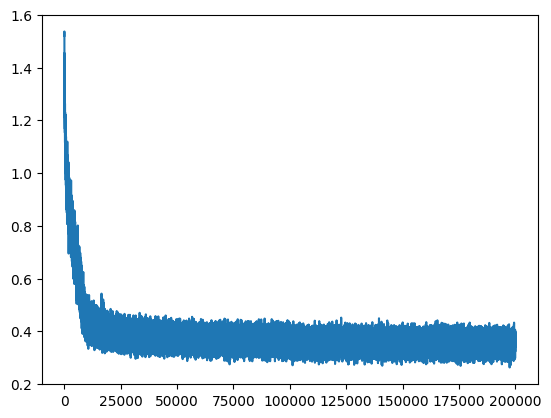

In [8]:
plt.plot(steps, losses)

In [9]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.2776803970336914


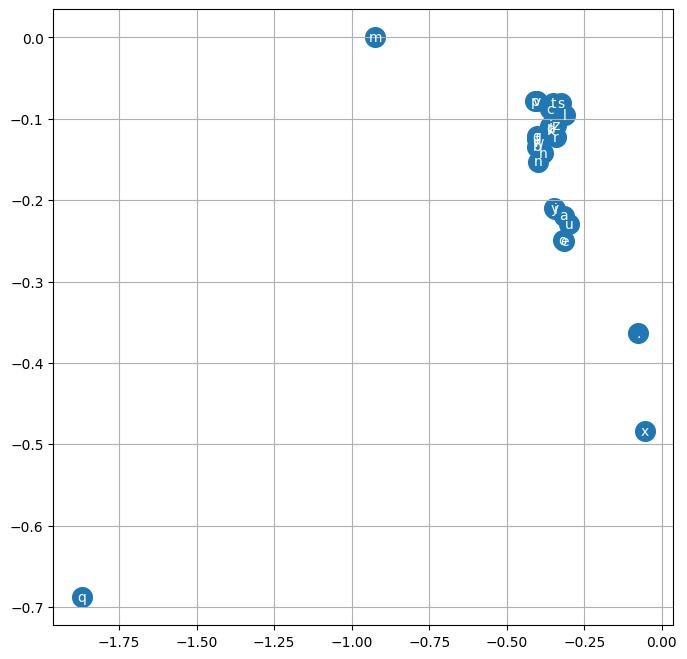

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid('minor')